In [1]:
import numpy as np
import matplotlib.pyplot as plt

import ssl

import torch
import torch.distributions as dist
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.utils as vutils

from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2
from torchvision import datasets

from PIL import Image

from scipy import linalg

from pathlib import Path
from tqdm import tqdm
from typing import Tuple, Any, Optional

device = "cuda" if torch.cuda.is_available() else "cpu"

ssl._create_default_https_context = ssl._create_unverified_context

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according 

In [2]:
path = Path("/kaggle/input/image-faces/faces")

In [3]:
class BaseDataset(Dataset):
    """
    Base dataset class that processes data and targets through optional transforms.
    """
    def __init__(
        self,
        data,
        transform = None,
    ) -> None:
        self.data = data
        self.transform = transform

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx) -> Tuple[Any, Any]:
        datum = self.data[idx]

        if self.transform is not None:
            datum = self.transform(datum)

        return datum

class DataModule:
    def __init__(self, batch_size, num_workers, on_gpu, shuffle):
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.on_gpu = on_gpu
        self.shuffle = shuffle

    def prepare_data(self, *args, **kwargs) -> None:
        pass

    def setup(self, stage: Optional[str] = None) -> None:
        pass

    def train_dataloader(self):
        return DataLoader(
            dataset = self.train_dataset,
            batch_size = self.batch_size,
            shuffle = self.shuffle,
            num_workers = self.num_workers,
            pin_memory = self.on_gpu
        )

    def val_dataloader(self):
        return DataLoader(
            dataset = self.val_dataset,
            batch_size = self.batch_size,
            shuffle = False,
            num_workers = self.num_workers,
            pin_memory = self.on_gpu
        )

    def test_dataloader(self):
        return DataLoader(
            dataset = self.test_dataset,
            batch_size = self.batch_size,
            shuffle = False,
            num_workers = self.num_workers,
            pin_memory = self.on_gpu
        )        

def split_dataset(
    base_dataset: BaseDataset,
    fraction: float,
    seed: int
) -> Tuple[BaseDataset, BaseDataset]:
    first_split_size = int(len(base_dataset) * fraction)
    second_split_size = len(base_dataset) - first_split_size

    return torch.utils.data.random_split(
        dataset = base_dataset,
        lengths = [first_split_size, second_split_size],
        generator = torch.Generator().manual_seed(seed)
    )

In [4]:
class Faces(DataModule):
    def __init__(self, resize, batch_size=8, num_workers=2, on_gpu=True, shuffle=True):
        super().__init__(batch_size, num_workers, on_gpu, shuffle)
        self.resize = resize
        transforms = v2.Compose([
            v2.Resize((self.resize)),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.transforms = transforms

    def prepare_data(self):
        self.data_dir = Path("/kaggle/input/image-faces/faces")

    def setup(self):
        def _load_dataset(transform):
            images = self._load_images()
            return BaseDataset(images, transform)

        self.train_dataset = _load_dataset(self.transforms)

    def _load_images(self):
        image_files = self.data_dir.glob("*")
        return [Image.open(file).convert("RGB") for file in image_files]
        

In [5]:
data_module = Faces(resize=(64, 64))
data_module.prepare_data()
data_module.setup()

In [6]:
data = [x[None, :, :, :] for x in data_module.train_dataset]
data = torch.cat(data)
# data[0].shape

In [7]:
pictures = vutils.make_grid(data, padding=2, normalize=True)

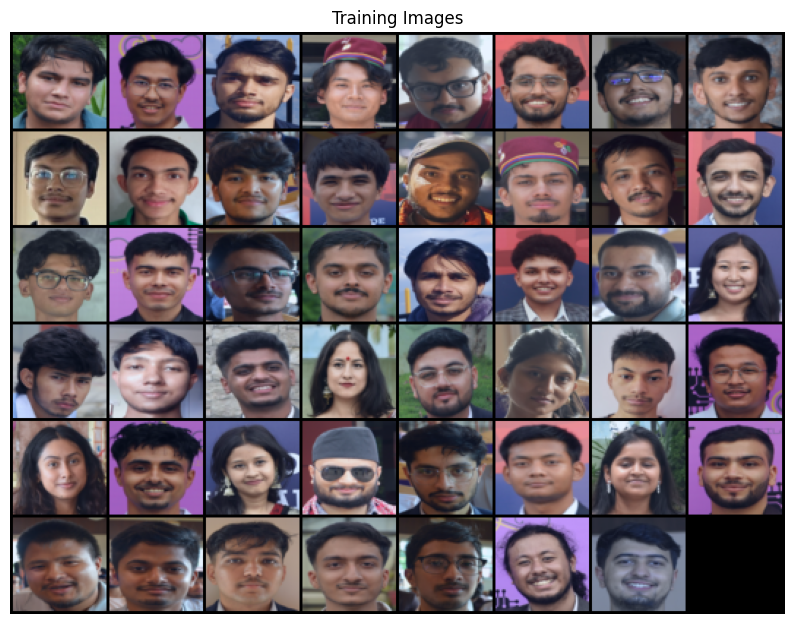

In [8]:
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(pictures.permute(1, 2, 0))
plt.savefig("training_images.png")

In [9]:
dataloader = data_module.train_dataloader()

## Architecture

In [10]:
class GBlock(nn.Module):
    def __init__(
        self, 
        in_channels: int, 
        out_channels: int,
        kernel_size: int | Tuple[int, int] = (4, 4),
        stride: int | Tuple[int, int] = 2,
        padding: int | Tuple[int, int] = 1,
        bias: bool = False,
    ):
        super().__init__()
        self.gblock = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.gblock(x)

class Generator(nn.Module):
    def __init__(
        self,
        nz: int = 100,
        ngf: int = 128,
        nc: int = 3
    ):
        super().__init__()
        self.net = nn.Sequential(
            GBlock(
                in_channels=nz, 
                out_channels=ngf*8,
                stride=1,
                padding=0
            ),
            GBlock(in_channels=ngf*8, out_channels=ngf*4),
            GBlock(in_channels=ngf*4, out_channels=ngf*2),
            GBlock(in_channels=ngf*2, out_channels=ngf),
            nn.ConvTranspose2d(
                in_channels=ngf,
                out_channels=nc,
                kernel_size=(4, 4),
                stride=2,
                padding=1,
                bias=False
            ),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)

class DBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int | Tuple[int, int] = (4, 4),
        stride: int | Tuple[int, int] = 2,
        padding: int | Tuple[int, int] = 1,
        bias: bool = False,
        alpha: float = 0.2
    ):
        super().__init__()
        self.dblock = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(alpha, inplace=True),
        )

    def forward(self, x):
        return self.dblock(x)

class Discriminator(nn.Module):
    def __init__(
        self,
        ndf: int = 128,
        nc: int = 3
    ):
        super().__init__()
        self.net = nn.Sequential(
            DBlock(in_channels=nc, out_channels=ndf),
            DBlock(in_channels=ndf, out_channels=ndf*2),
            DBlock(in_channels=ndf*2, out_channels=ndf*4),
            DBlock(in_channels=ndf*4, out_channels=ndf*8),
            nn.Conv2d(in_channels=ndf*8, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [11]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp

block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[192]
model = InceptionV3([block_idx])
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 220MB/s] 


In [12]:
def calculate_activation_statistics(images,model,batch_size=128, dims=2048,
                    device="cuda"):
    model.eval()
    act=np.empty((len(images), dims))
    
    batch = images.to(device)
    pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = F.adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma


In [13]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)


In [14]:
def calculate_fretchet(images_real,images_fake,model, device):
     mu_1,std_1=calculate_activation_statistics(images_real,model,device)
     mu_2,std_2=calculate_activation_statistics(images_fake,model,device)
    
     """get fretched distance"""
     fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
     return fid_value

## Training

In [15]:
NUM_EPOCHS = 100
NZ = 100
NC = 3
NGF = 128
NDF = 128

LR = 2e-4
EPOCHS = 5
BETA1 = 0.9
BETA2 = 0.999

REAL_LABEL = 1
FAKE_LABEL = 0

G = Generator(nz=NZ, ngf=NGF, nc=NC)
D = Discriminator(ndf=NDF, nc=NC)
G, D = G.to(device), D.to(device)

criterion = nn.BCELoss()

G_optimizer = optim.Adam(G.parameters(), lr=LR)
D_optimizer = optim.Adam(D.parameters(), lr=LR)

In [16]:
# transform=v2.Compose([
#                                v2.Resize((64, 64)),
#                                v2.CenterCrop((64, 64)),
#                                v2.ToTensor(),
#                                v2.Normalize((0,0,0), (1,1,1)),])


# dataset = datasets.CIFAR10(root='cifar10', train=True,
#                                         download=True, transform=transform)
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=128,
#                                           shuffle=True, num_workers=2)

In [ ]:
ngf = 128
num_epochs=200
real_label=1
fake_label=0
nz = 100

img_list = []
G_losses = []
D_losses = []
FID = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        D.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float32, device=device)
#         # add some noise to the input to discriminator
        
        real_cpu=0.9*real_cpu+0.1*torch.randn((real_cpu.size()), device=device)
        # Forward pass real batch through D
        output = D(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()
        
        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = G(noise)
        label.fill_(fake_label)
        
        fake=0.9*fake+0.1*torch.randn((fake.size()), device=device)
        # Classify all fake batch with D
        output = D(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        D_optimizer.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = D(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        D_G_z2 = output.mean().item()
        
        # Calculate gradients for G
        errG.backward()
        # Update G
        G_optimizer.step()
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 50 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            with torch.no_grad():
                fixed_noise = torch.randn(ngf, nz, 1, 1, device=device)
                fake_display = G(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake_display, padding=2, normalize=True))
            
         
            
        iters += 1   
    G_losses.append(errG.item())
    D_losses.append(errD.item())     
    fretchet_dist=calculate_fretchet(real_cpu,fake,model, device=device) 
    FID.append(fretchet_dist)
    if ((epoch+1)%5==0):
        
        print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tFretchet_Distance: %.4f'
                      % (epoch+1, num_epochs,
                         errD.item(), errG.item(),fretchet_dist))
        
        
        plt.figure(figsize=(8,8))
        plt.axis("off")
        pictures=vutils.make_grid(fake_display[torch.randint(len(fake_display), (10,))],nrow=5,padding=2, normalize=True)
        plt.imshow(np.transpose(pictures,(1,2,0)))
        plt.show()

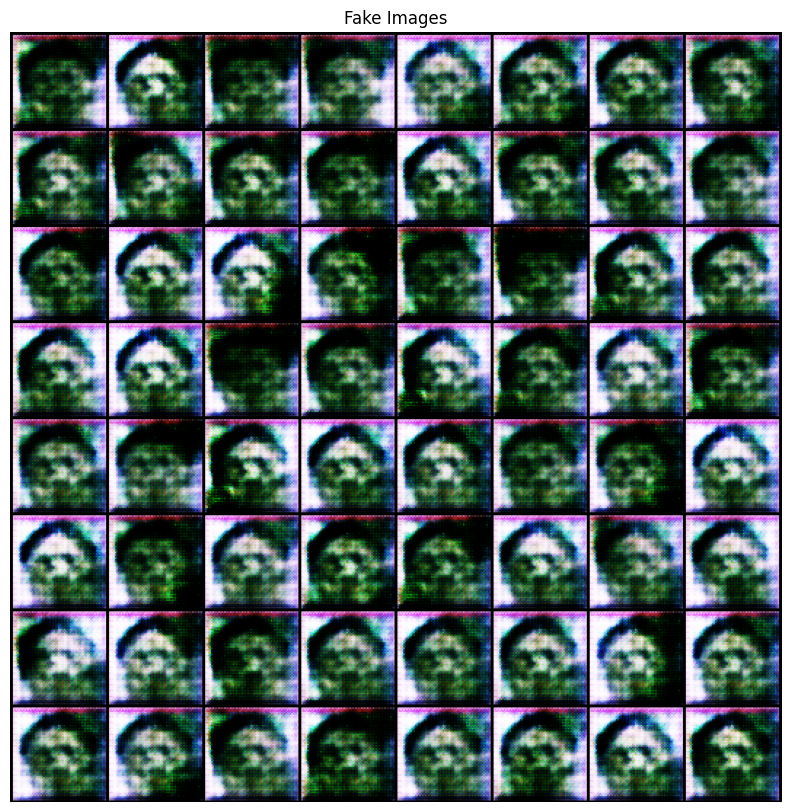

In [29]:
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(img_list[-3].permute(1, 2, 0)[:529, :, :])
# plt.show()
plt.savefig("result.png")

In [26]:
img_list[-3].shape

torch.Size([3, 1058, 530])

In [20]:
img_list[-1].shape

torch.Size([3, 1058, 530])

In [21]:
fixed_noise = torch.randn(64, 100, 1, 1).to(device)
pictures = vutils.make_grid(G(fixed_noise).detach().cpu(), padding=2, normalize=True)

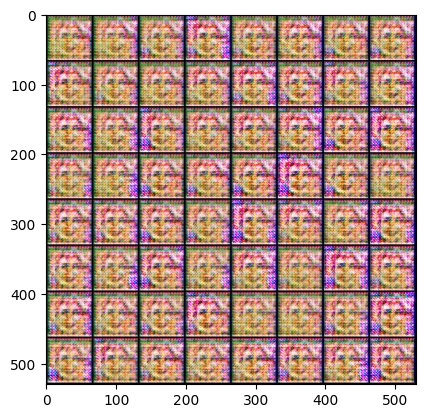

In [22]:
plt.imshow(pictures.permute(1, 2, 0))

In [ ]:
# loss_D

NameError: name 'loss_D' is not defined

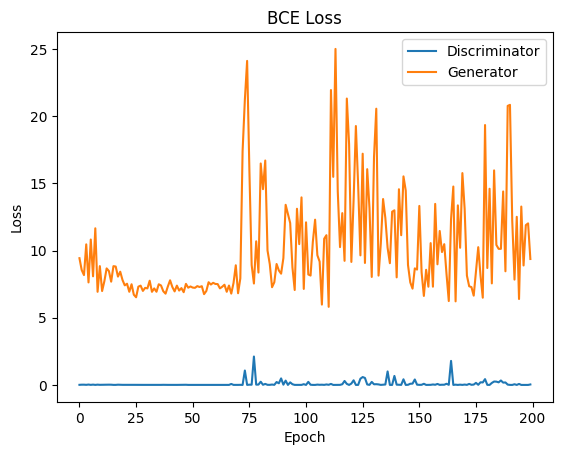

In [27]:
plt.plot(D_losses, label="Discriminator")
plt.plot(G_losses, label="Generator")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("BCE Loss")
# plt.show()
plt.savefig("loss_curve.png")

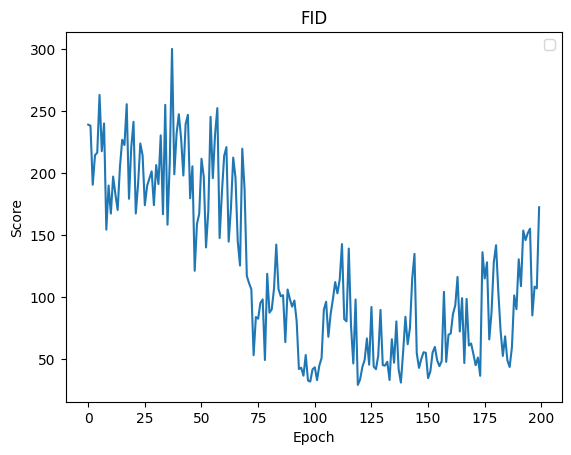

In [28]:
plt.plot(FID)
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.title("FID")
# plt.show()
plt.savefig("fid.png")